You can check [here](https://github.com/facebookresearch/detectron2/blob/master/INSTALL.md) to get needed environment, but you don't need to worry it in colab.

In [1]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 703.8MB 26kB/s 
     |████████████████████████████████| 6.6MB 25.7MB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101
     |████████████████████████████████| 276kB 2.6MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44075 sha256=e4b9fe429ce1910190ccb386d067d3890b3f8801569d5c81e93890390084b868
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip

In [2]:
!git clone https://github.com/tangsanli5201/DeepPCB
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Cloning into 'DeepPCB'...
remote: Enumerating objects: 4753, done.
remote: Total 4753 (delta 0), reused 0 (delta 0), pack-reused 4753
Receiving objects: 100% (4753/4753), 85.81 MiB | 16.93 MiB/s, done.
Resolving deltas: 100% (191/191), done.
Checking out files: 100% (4548/4548), done.
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
     |████████████████████████████████| 6.2MB 381kB/s 
  Created wheel for fvcore: filename=fvcore-0.1.2.post20201020-cp36-none-any.whl size=44210 sha256=a023f791ad66883474c5e7245642c6c1e3334fa57649df944a2bba86569d2991
  Stored in directory: /root/.cache/pip/wheels/71/6c/b5/198f89a5c5f127327730248cc623e5a307ad11ed287c3fe391
Successfully built fvcore


In [3]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [4]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from matplotlib.pyplot import imshow
from PIL import Image
import IPython
def cv2_imshow(img):
    img = img[:,:,[2,1,0]]
    img = Image.fromarray(img)
    plt.figure(figsize=(20, 20))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

We have to take the data out from the .txt file.

In [5]:
import csv
train, test = [],[]
def take_path(x,d):
    with open(d) as t:
        #print(t.read())
        #print(type(csv.reader(t)))
        tmp = csv.reader(t,delimiter=' ')
        for i in tmp:
            x.append(i)
        for ele in x:
            ele[0] = './DeepPCB/PCBData/'+ele[0][:-4]+'_test.jpg'
            ele[1] = './DeepPCB/PCBData/'+ele[1]

take_path(test,'./DeepPCB/PCBData/test.txt')
print(test[:2])
take_path(train,'./DeepPCB/PCBData/trainval.txt')
print(train[:2])


[['./DeepPCB/PCBData/group20085/20085/20085291_test.jpg', './DeepPCB/PCBData/group20085/20085_not/20085291.txt'], ['./DeepPCB/PCBData/group20085/20085/20085292_test.jpg', './DeepPCB/PCBData/group20085/20085_not/20085292.txt']]
[['./DeepPCB/PCBData/group20085/20085/20085000_test.jpg', './DeepPCB/PCBData/group20085/20085_not/20085000.txt'], ['./DeepPCB/PCBData/group20085/20085/20085001_test.jpg', './DeepPCB/PCBData/group20085/20085_not/20085001.txt']]


In [6]:
height, width = cv2.imread(test[0][0]).shape[:2]
print(height, width)


640 640


# New Section

In [7]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

#DatasetCatalog.clear()
#If you want to clear the data you registered, uncomment the upper line.

def get_PCB_dict(data_list):
    dataset_dicts = []
    
    for i,path in enumerate(data_list):
        filename = path[0]
        height, width = cv2.imread(filename).shape[:2]
        record = {}
        record['file_name'] = filename
        record['image_id'] = i
        record['height']= height
        record['width']= width
            
        objs = []
        with open(path[1]) as t:
            print(path[1])
            lines = t.readlines()
            print(lines)
            for line in lines:
                if line[-1]=="\n":
                  box = line[:-1].split(' ')
                else:
                  box = line.split(' ')
                print(box)
                boxes = list(map(float,[box[0],box[1],box[2],box[3]]))
                category = int(box[4])
                print(boxes)
                obj = {
                    "bbox": boxes,
                    "bbox_mode": BoxMode.XYXY_ABS,
                    #"segmentation": [poly], To draw a line, along to ballon
                    #you will need this for mask RCNN
                    "category_id": category-1,
                    "iscrowd": 0
                }
                print(obj)
                objs.append(obj)
            record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts #list of dicts

In [8]:
from detectron2.data import DatasetCatalog, MetadataCatalog
for d,x in [("train",train), ("test",test)]:
    DatasetCatalog.register("PCB_" + d, lambda x=x: get_PCB_dict(x))
    MetadataCatalog.get("PCB_" + d).set(thing_classes=["open", "short", "mousebite", "spur", "copper", "pin-hole"],thing_colors=[(255,0,0),(0,255,0),(0,0,255),(255,255,0),(255,0,255),(0,255,255)])
    #I set the colors, but it's no use. Retry after training.
PCB_metadata = MetadataCatalog.get("PCB_train")

In [9]:
#check dataset
print(type(PCB_metadata))

MetadataCatalog.get("PCB_test")

<class 'detectron2.data.catalog.Metadata'>


Metadata(name='PCB_test', thing_classes=['open', 'short', 'mousebite', 'spur', 'copper', 'pin-hole'], thing_colors=[(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255), (0, 255, 255)])

Get all the data and check the content inside

In [10]:
dataset_dicts = get_PCB_dict(train)

串流輸出內容已截斷至最後 5000 行。
[492.0, 393.0, 529.0, 426.0]
{'bbox': [492.0, 393.0, 529.0, 426.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 5, 'iscrowd': 0}
['247', '200', '291', '230', '4']
[247.0, 200.0, 291.0, 230.0]
{'bbox': [247.0, 200.0, 291.0, 230.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 3, 'iscrowd': 0}
./DeepPCB/PCBData/group77000/77000_not/77000052.txt
['109 443 135 480 1\n', '523 439 574 474 2\n', '180 191 228 234 2\n', '163 267 198 304 4\n', '81 219 124 256 6\n']
['109', '443', '135', '480', '1']
[109.0, 443.0, 135.0, 480.0]
{'bbox': [109.0, 443.0, 135.0, 480.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0, 'iscrowd': 0}
['523', '439', '574', '474', '2']
[523.0, 439.0, 574.0, 474.0]
{'bbox': [523.0, 439.0, 574.0, 474.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 1, 'iscrowd': 0}
['180', '191', '228', '234', '2']
[180.0, 191.0, 228.0, 234.0]
{'bbox': [180.0, 191.0, 228.0, 234.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 1, 'iscrowd':

In [11]:
print(dataset_dicts[0])
print(dataset_dicts[1])

{'file_name': './DeepPCB/PCBData/group20085/20085/20085000_test.jpg', 'image_id': 0, 'height': 640, 'width': 640, 'annotations': [{'bbox': [409.0, 394.0, 435.0, 422.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 2, 'iscrowd': 0}, {'bbox': [275.0, 383.0, 319.0, 417.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 2, 'iscrowd': 0}, {'bbox': [8.0, 163.0, 36.0, 191.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 3, 'iscrowd': 0}, {'bbox': [244.0, 151.0, 270.0, 182.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 4, 'iscrowd': 0}, {'bbox': [338.0, 519.0, 364.0, 543.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 5, 'iscrowd': 0}, {'bbox': [476.0, 460.0, 502.0, 481.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 3, 'iscrowd': 0}]}
{'file_name': './DeepPCB/PCBData/group20085/20085/20085001_test.jpg', 'image_id': 1, 'height': 640, 'width': 640, 'annotations': [{'bbox': [335.0, 208.0, 364.0, 233.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 2, '

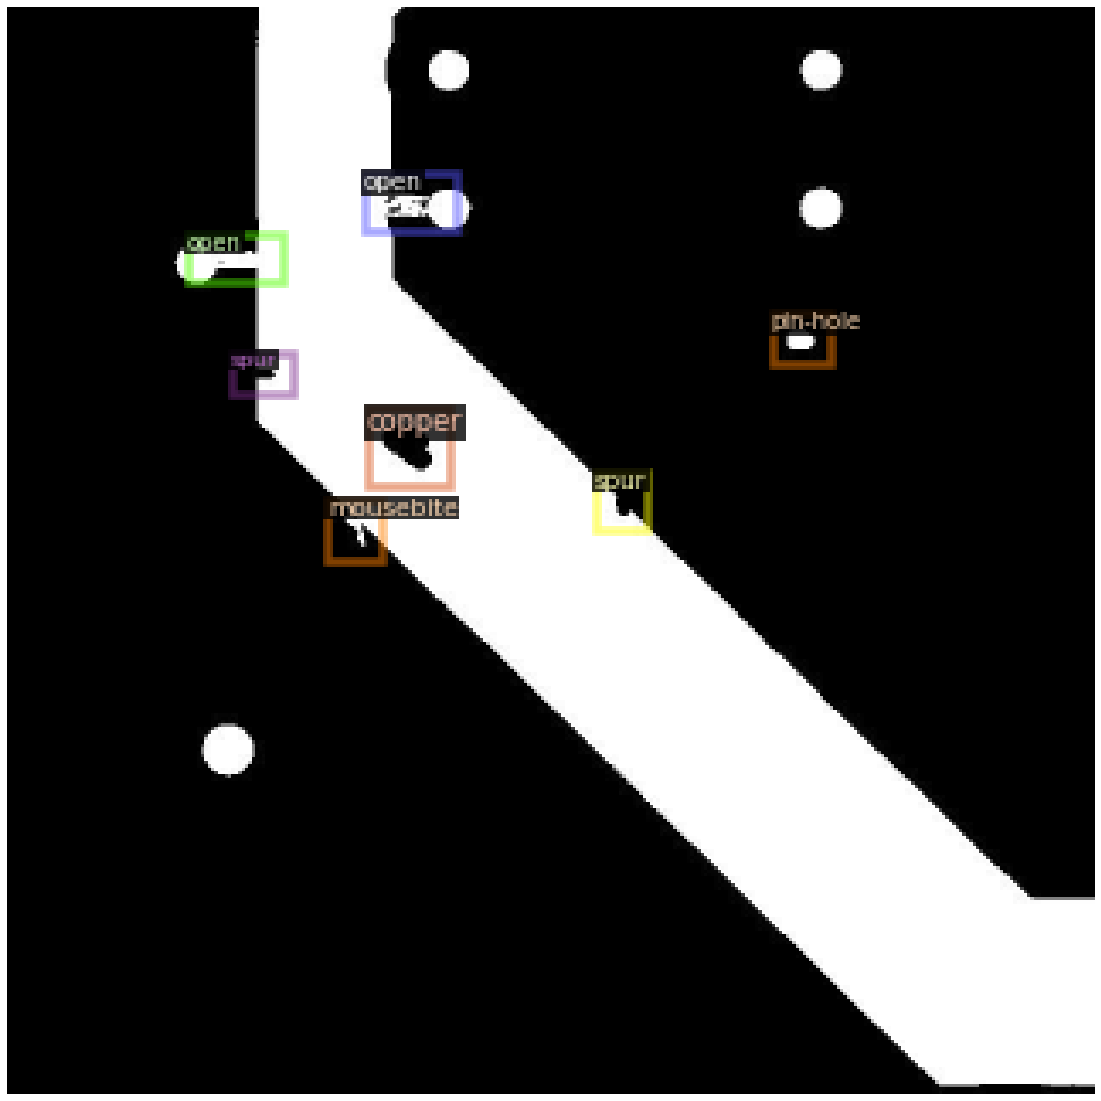

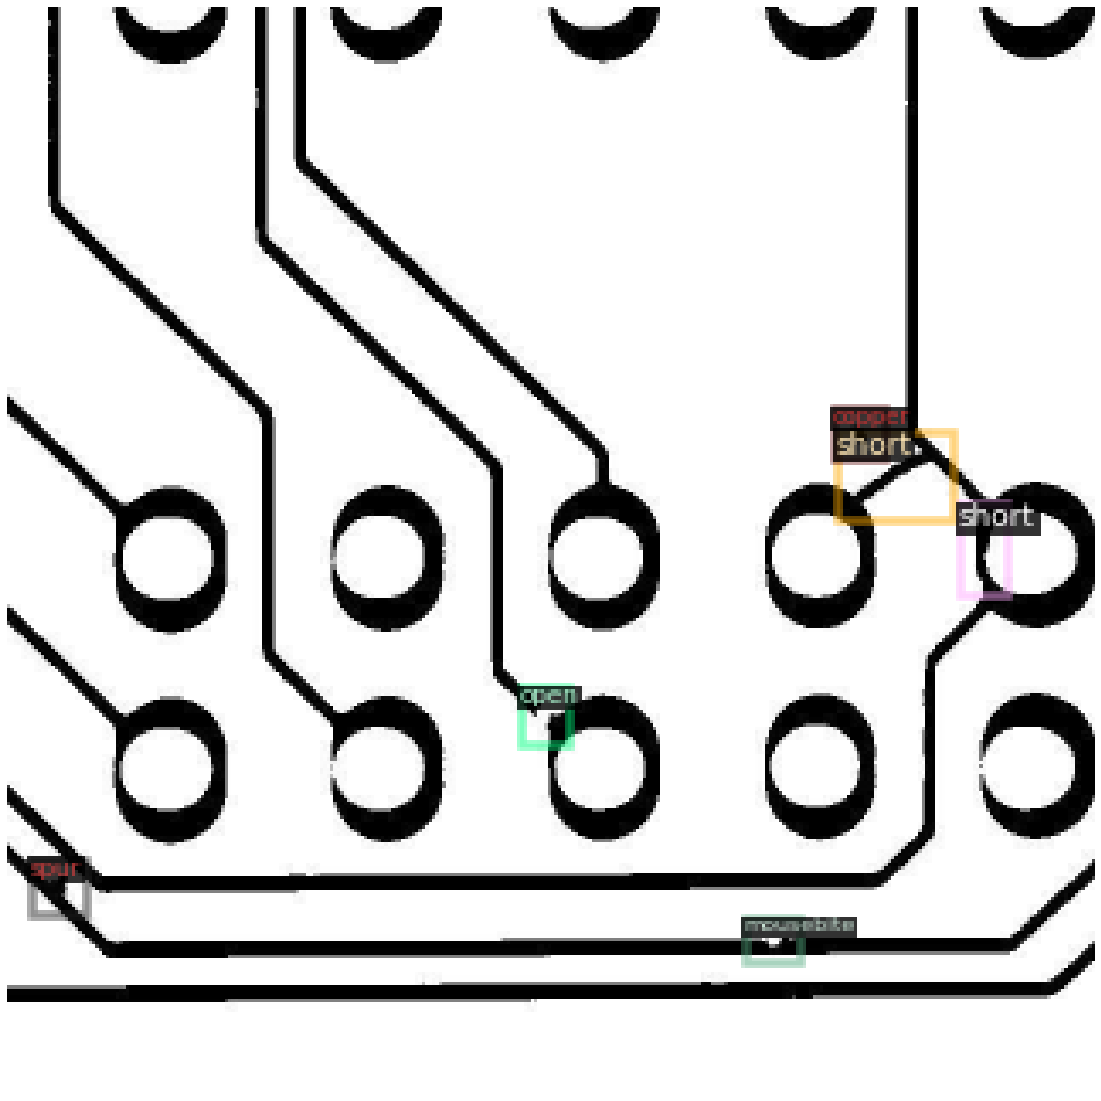

In [12]:
for d in random.sample(dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=PCB_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [13]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("PCB_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 0
cfg.MODEL.WEIGHTS = "detectron2://COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl"  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1500    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 4096   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6 

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()
#It will train about 20 minutes in colab.

串流輸出內容已截斷至最後 5000 行。
{'bbox': [523.0, 439.0, 574.0, 474.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 1, 'iscrowd': 0}
['180', '191', '228', '234', '2']
[180.0, 191.0, 228.0, 234.0]
{'bbox': [180.0, 191.0, 228.0, 234.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 1, 'iscrowd': 0}
['163', '267', '198', '304', '4']
[163.0, 267.0, 198.0, 304.0]
{'bbox': [163.0, 267.0, 198.0, 304.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 3, 'iscrowd': 0}
['81', '219', '124', '256', '6']
[81.0, 219.0, 124.0, 256.0]
{'bbox': [81.0, 219.0, 124.0, 256.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 5, 'iscrowd': 0}
./DeepPCB/PCBData/group77000/77000_not/77000053.txt
['213 304 248 347 5\n']
['213', '304', '248', '347', '5']
[213.0, 304.0, 248.0, 347.0]
{'bbox': [213.0, 304.0, 248.0, 347.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 4, 'iscrowd': 0}
./DeepPCB/PCBData/group77000/77000_not/77000054.txt
['153 117 201 149 1\n', '255 130 284 162 3\n', '351 467 379 500 5\n

model_final_280758.pkl: 167MB [00:11, 14.6MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (7, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (7,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (24, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (24,) in the model! You might want to double check if this is expected.


[10/26 13:03:43 d2.engine.train_loop]: Starting training from iteration 0
[10/26 13:04:03 d2.utils.events]:  eta: 0:25:10  iter: 19  total_loss: 2.487  loss_cls: 1.842  loss_box_reg: 0.028  loss_rpn_cls: 0.462  loss_rpn_loc: 0.150  time: 0.9995  data_time: 0.0444  lr: 0.000005  max_mem: 1829M
[10/26 13:04:23 d2.utils.events]:  eta: 0:24:18  iter: 39  total_loss: 2.316  loss_cls: 1.703  loss_box_reg: 0.046  loss_rpn_cls: 0.407  loss_rpn_loc: 0.150  time: 0.9999  data_time: 0.0430  lr: 0.000010  max_mem: 1829M
[10/26 13:04:44 d2.utils.events]:  eta: 0:24:22  iter: 59  total_loss: 1.878  loss_cls: 1.303  loss_box_reg: 0.038  loss_rpn_cls: 0.275  loss_rpn_loc: 0.169  time: 1.0152  data_time: 0.0472  lr: 0.000015  max_mem: 1829M
[10/26 13:05:05 d2.utils.events]:  eta: 0:24:20  iter: 79  total_loss: 1.397  loss_cls: 0.930  loss_box_reg: 0.025  loss_rpn_cls: 0.279  loss_rpn_loc: 0.159  time: 1.0254  data_time: 0.0451  lr: 0.000020  max_mem: 1829M
[10/26 13:05:25 d2.utils.events]:  eta: 0:23:4

In [14]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3   # set the testing threshold for this model
cfg.DATASETS.TEST = ("PCB_test", )
predictor = DefaultPredictor(cfg)

In [15]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_PCB_dict(test)

串流輸出內容已截斷至最後 5000 行。
[53.0, 395.0, 80.0, 425.0]
{'bbox': [53.0, 395.0, 80.0, 425.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0, 'iscrowd': 0}
['210', '216', '241', '248', '1']
[210.0, 216.0, 241.0, 248.0]
{'bbox': [210.0, 216.0, 241.0, 248.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0, 'iscrowd': 0}
['309', '233', '334', '264', '3']
[309.0, 233.0, 334.0, 264.0]
{'bbox': [309.0, 233.0, 334.0, 264.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 2, 'iscrowd': 0}
['536', '167', '570', '204', '5']
[536.0, 167.0, 570.0, 204.0]
{'bbox': [536.0, 167.0, 570.0, 204.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 4, 'iscrowd': 0}
['386', '293', '422', '328', '6']
[386.0, 293.0, 422.0, 328.0]
{'bbox': [386.0, 293.0, 422.0, 328.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 5, 'iscrowd': 0}
['445', '485', '484', '521', '5']
[445.0, 485.0, 484.0, 521.0]
{'bbox': [445.0, 485.0, 484.0, 521.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 4, 'iscrowd': 

tensor([1, 5, 4, 3, 0, 5, 1, 0, 2, 3, 4, 3, 2, 0], device='cuda:0')
Boxes(tensor([[ 91.5553, 454.6007, 114.2205, 487.3964],
        [282.6362, 256.8978, 306.2323, 278.5382],
        [387.0251, 181.4744, 407.5857, 221.6777],
        [328.0399,  98.0728, 349.3524, 141.6904],
        [135.3804, 285.2420, 169.1674, 321.5551],
        [453.8828, 459.5862, 474.8704, 511.8100],
        [375.9628, 432.0716, 402.0080, 481.5012],
        [259.4816, 312.8756, 319.8025, 334.9855],
        [420.2773, 204.7091, 448.3404, 235.1105],
        [326.3251, 100.3600, 350.6412, 119.0528],
        [418.6098, 205.0289, 450.4182, 236.2279],
        [375.3697, 432.1152, 402.8043, 478.7583],
        [259.3634, 311.0693, 321.5892, 336.8072],
        [376.4447, 432.8834, 401.5203, 477.6738]], device='cuda:0'))


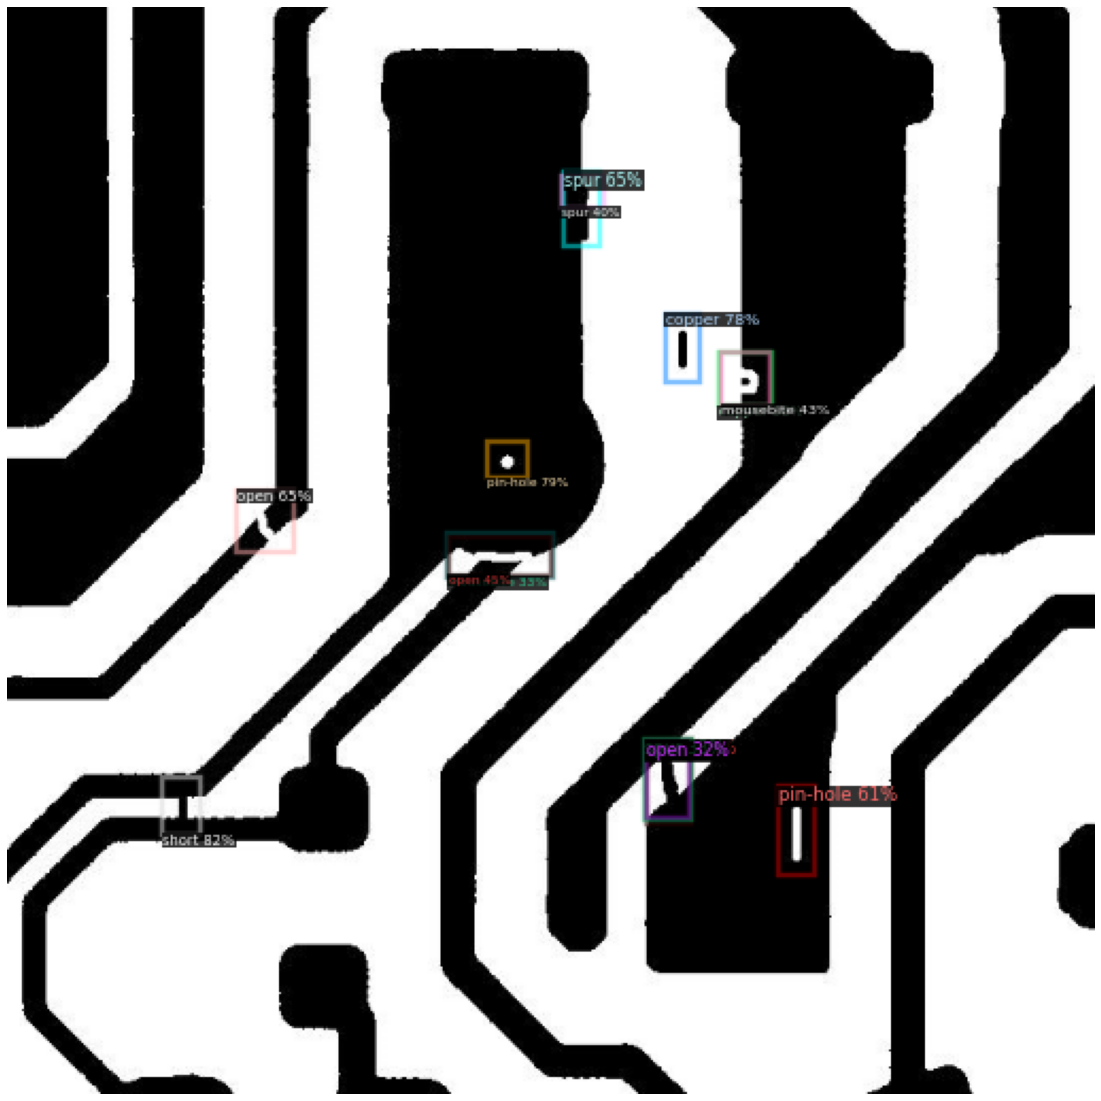

tensor([4, 5, 1, 2, 1, 1], device='cuda:0')
Boxes(tensor([[ 76.7645, 211.6176, 115.5306, 254.4590],
        [157.5567, 399.5617, 188.2537, 431.8810],
        [492.5515, 133.8027, 513.8221, 186.8779],
        [150.0052, 122.6851, 184.8082, 157.1631],
        [  0.0000, 100.0357,  31.6301, 157.8716],
        [521.9252, 466.1817, 566.9644, 507.4085]], device='cuda:0'))


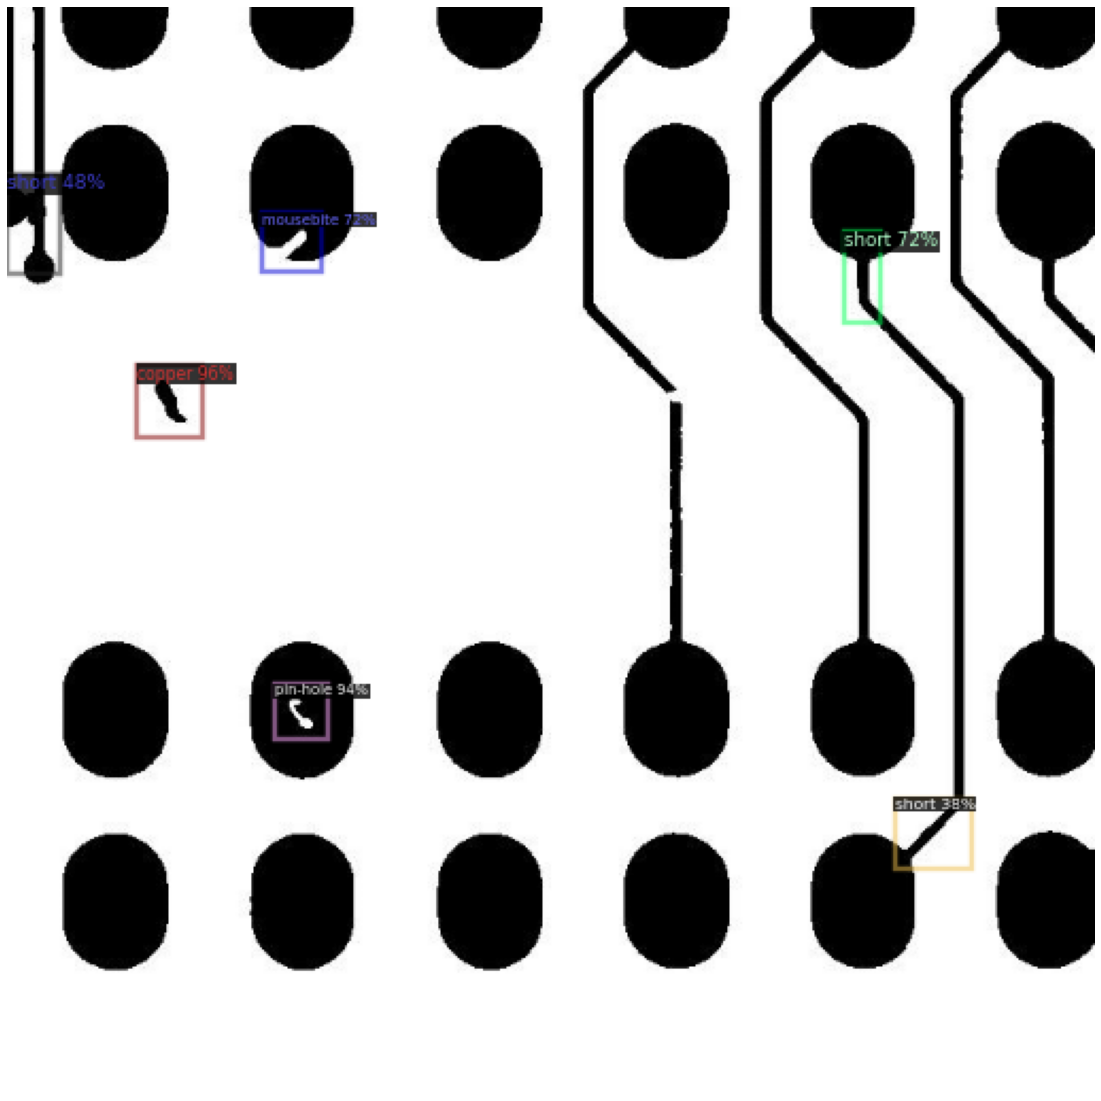

tensor([4, 0, 3, 5, 1, 2, 1, 5, 1, 2, 1], device='cuda:0')
Boxes(tensor([[360.1170, 168.7077, 397.2847, 198.0861],
        [282.4172, 352.8340, 339.2205, 408.4255],
        [219.5115, 167.8576, 251.5060, 197.2702],
        [337.4352,  39.3629, 386.8447,  63.9655],
        [407.2273, 318.6692, 429.5632, 378.2431],
        [202.2061, 223.6846, 239.7714, 262.3832],
        [349.7307, 508.3456, 380.3134, 572.2052],
        [202.3654, 224.0714, 240.2057, 262.3820],
        [154.8087, 120.1956, 201.2440, 147.7707],
        [340.5255,  41.3226, 387.5309,  63.2984],
        [351.4172, 533.2419, 379.4108, 566.6257]], device='cuda:0'))


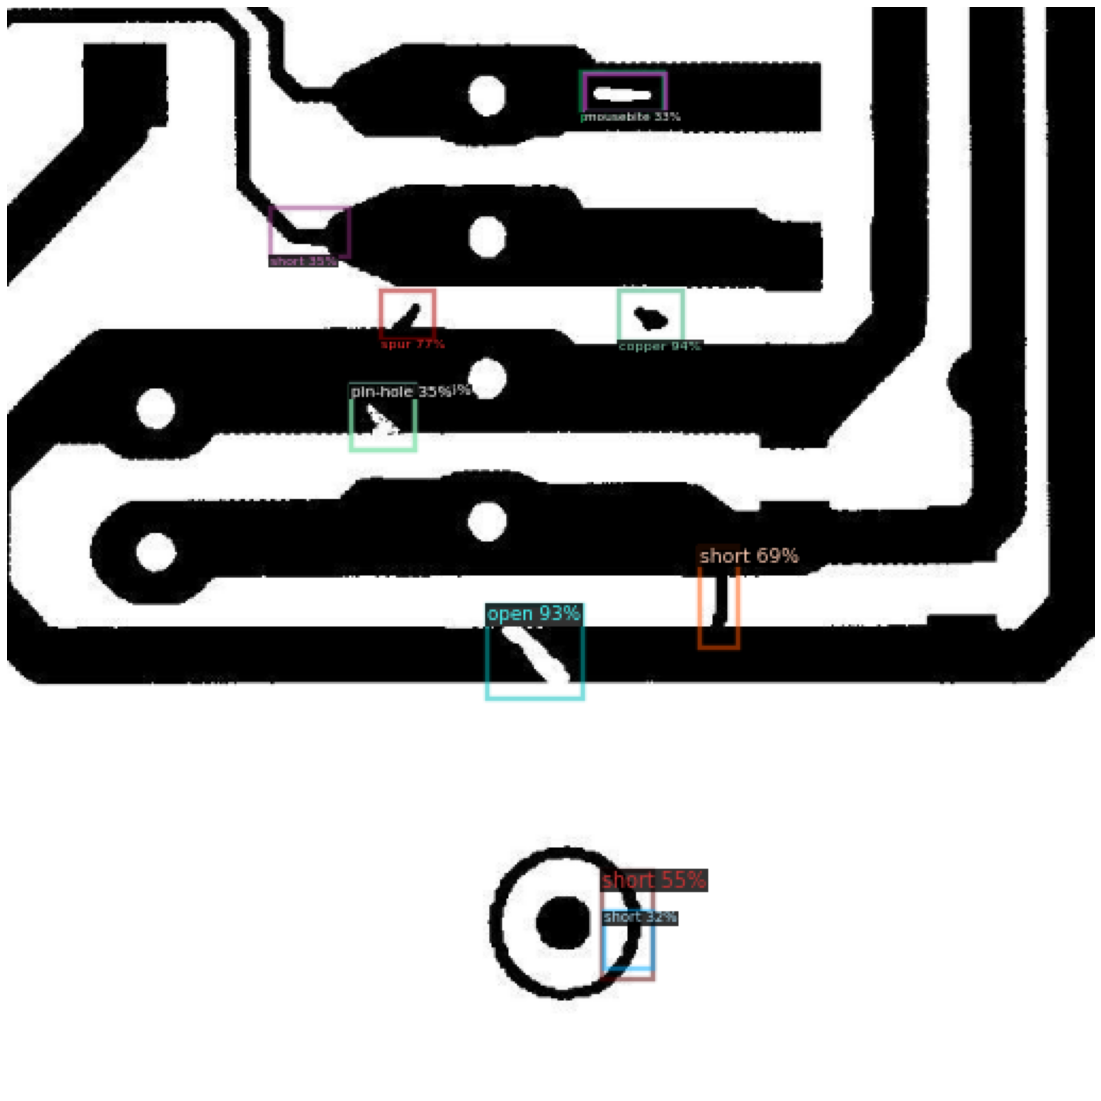

tensor([5, 0, 3, 2, 5, 5, 4, 0, 2, 4, 2, 3], device='cuda:0')
Boxes(tensor([[401.2177, 567.3586, 438.4067, 635.0038],
        [401.3310, 271.1831, 435.8950, 325.1609],
        [582.0145, 537.4543, 626.3759, 564.3978],
        [493.0902, 542.2768, 527.7855, 583.2726],
        [410.9319, 126.6954, 443.1985, 174.7792],
        [495.0399, 541.4850, 528.1619, 584.3879],
        [219.5874, 313.2168, 254.6620, 371.3338],
        [538.2243, 241.3167, 581.6160, 299.8075],
        [413.2135, 125.4598, 441.5532, 171.9373],
        [602.0492, 137.6025, 632.9736, 186.4108],
        [400.6626, 265.9191, 432.0118, 324.1074],
        [603.3398, 140.2394, 633.7745, 183.2924]], device='cuda:0'))


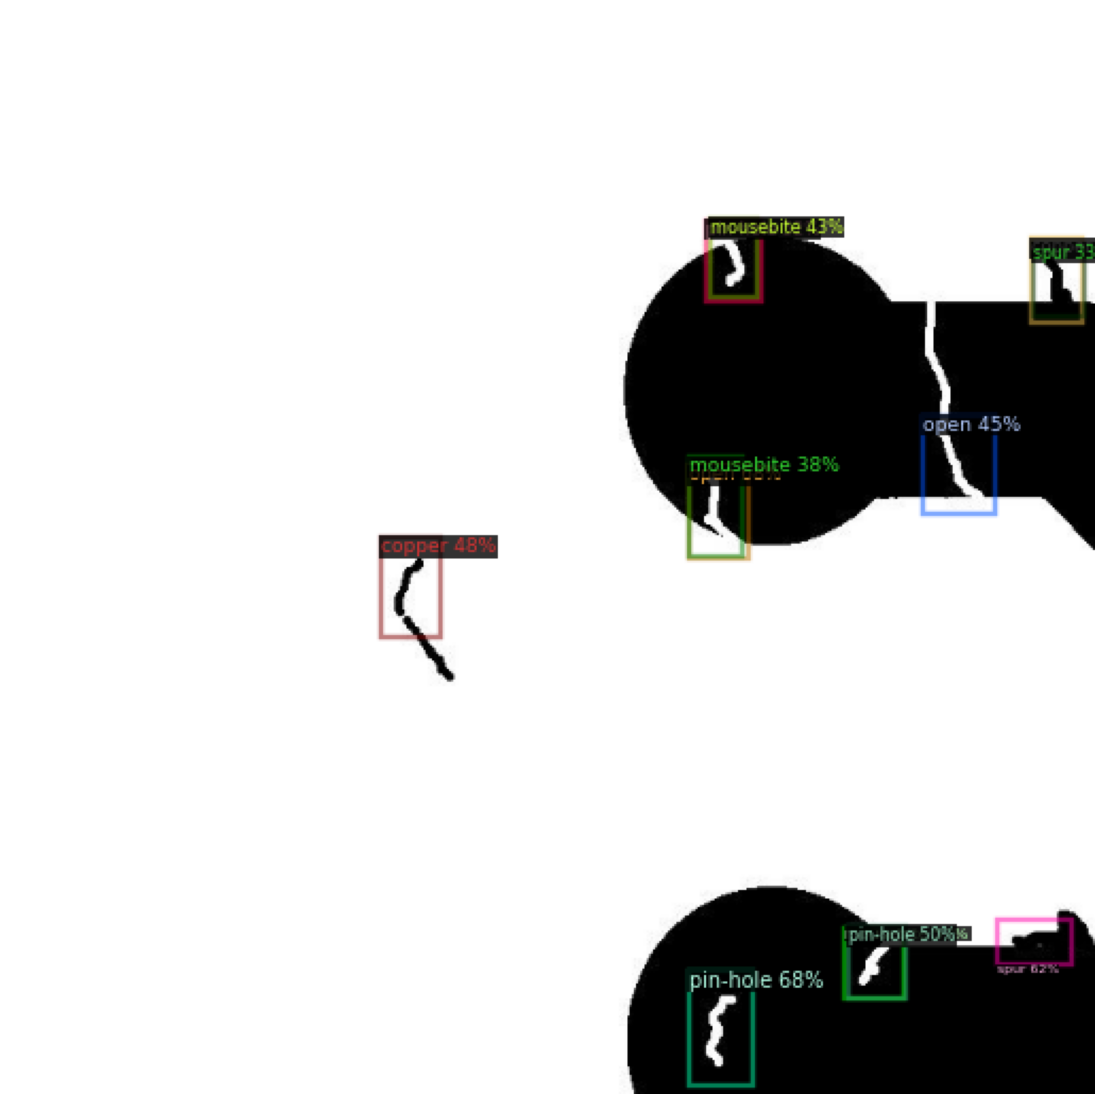

tensor([4, 1, 2, 5, 0, 4, 1, 1, 2], device='cuda:0')
Boxes(tensor([[321.6144, 561.4897, 364.4489, 598.3856],
        [374.1966, 322.3291, 430.7003, 346.7390],
        [378.8127, 509.2234, 408.6601, 537.6679],
        [391.5869, 564.0130, 413.5035, 603.9484],
        [337.6659, 302.1849, 358.1916, 319.7459],
        [260.2290, 453.6644, 293.8567, 486.2823],
        [459.3138, 399.2885, 506.1495, 438.3520],
        [ 70.8335, 612.3036, 104.0886, 640.0000],
        [390.8873, 562.7202, 413.4968, 600.8405]], device='cuda:0'))


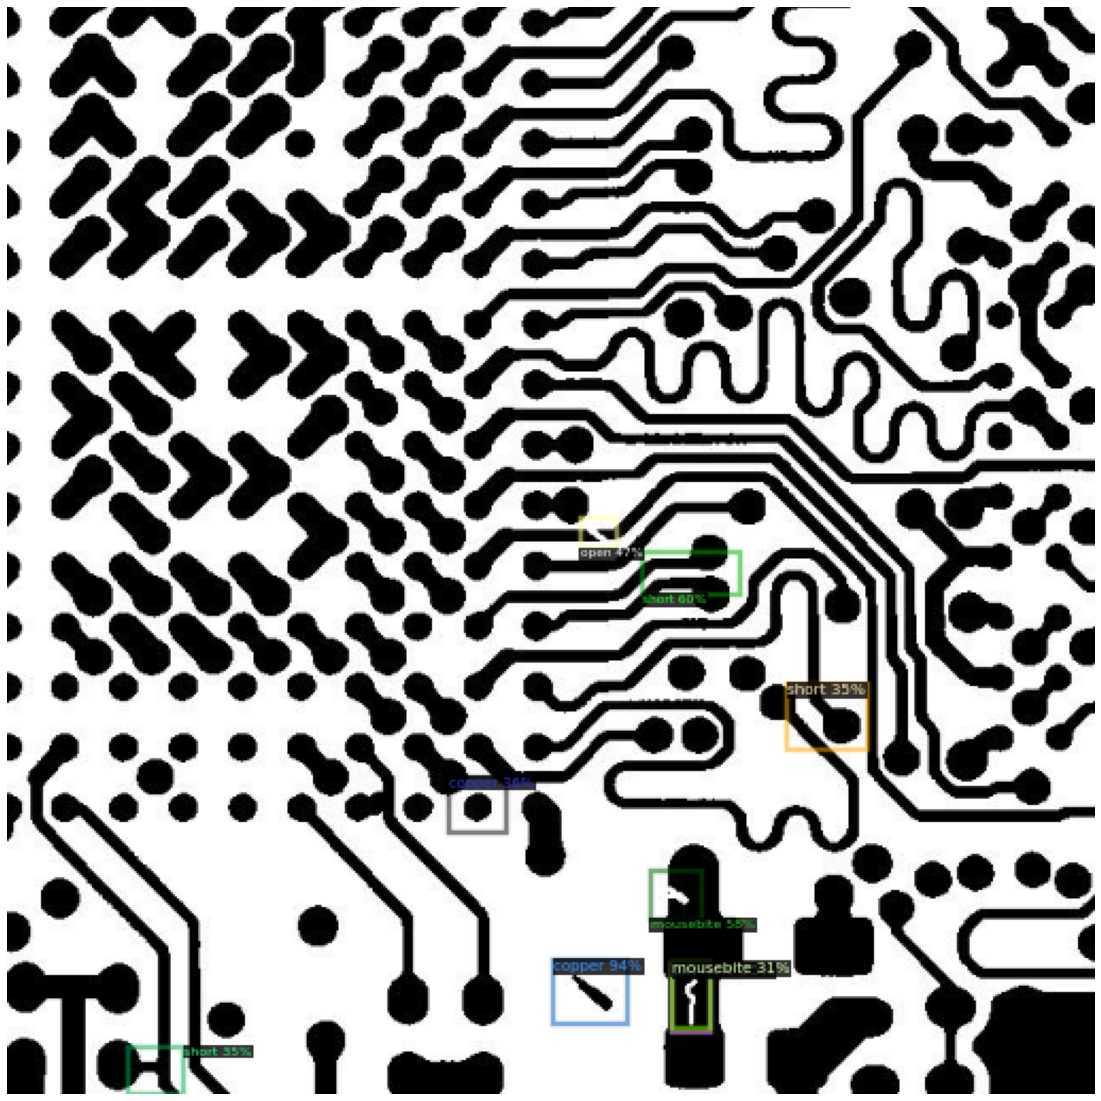

tensor([1, 1, 3, 0, 1, 3, 2], device='cuda:0')
Boxes(tensor([[304.8889, 432.8564, 325.7454, 468.3287],
        [399.3871, 466.5088, 434.1334, 512.1918],
        [401.4308, 466.3413, 436.1635, 505.4207],
        [347.4195, 427.1456, 378.4119, 456.8146],
        [104.7081, 477.9502, 149.8410, 512.9516],
        [109.4366, 481.0239, 147.3041, 509.3163],
        [349.5298, 426.9054, 379.1302, 453.9338]], device='cuda:0'))


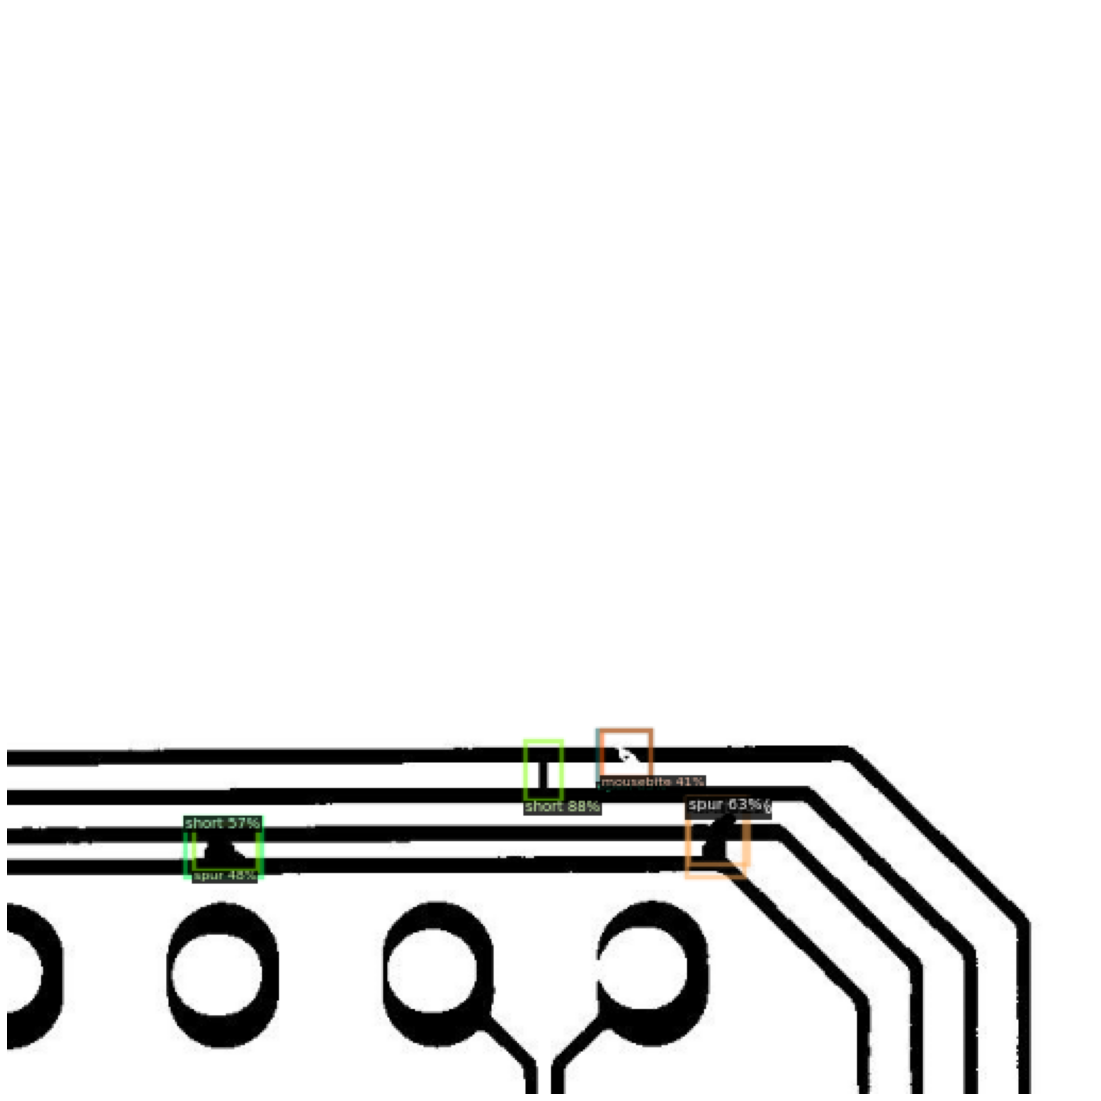

tensor([5, 5, 5, 5, 3, 5, 0, 2], device='cuda:0')
Boxes(tensor([[360.6434, 275.1362, 394.5285, 307.9721],
        [402.2885, 425.8023, 428.4027, 453.6365],
        [179.6110, 427.4101, 204.3766, 453.1905],
        [548.5241, 426.5843, 574.3584, 453.1904],
        [267.4448, 182.5024, 308.5506, 215.1508],
        [ 34.3397, 426.7922,  59.8323, 453.1214],
        [211.8181, 254.9267, 293.9396, 296.8781],
        [216.8704, 249.6260, 293.0704, 298.3128]], device='cuda:0'))


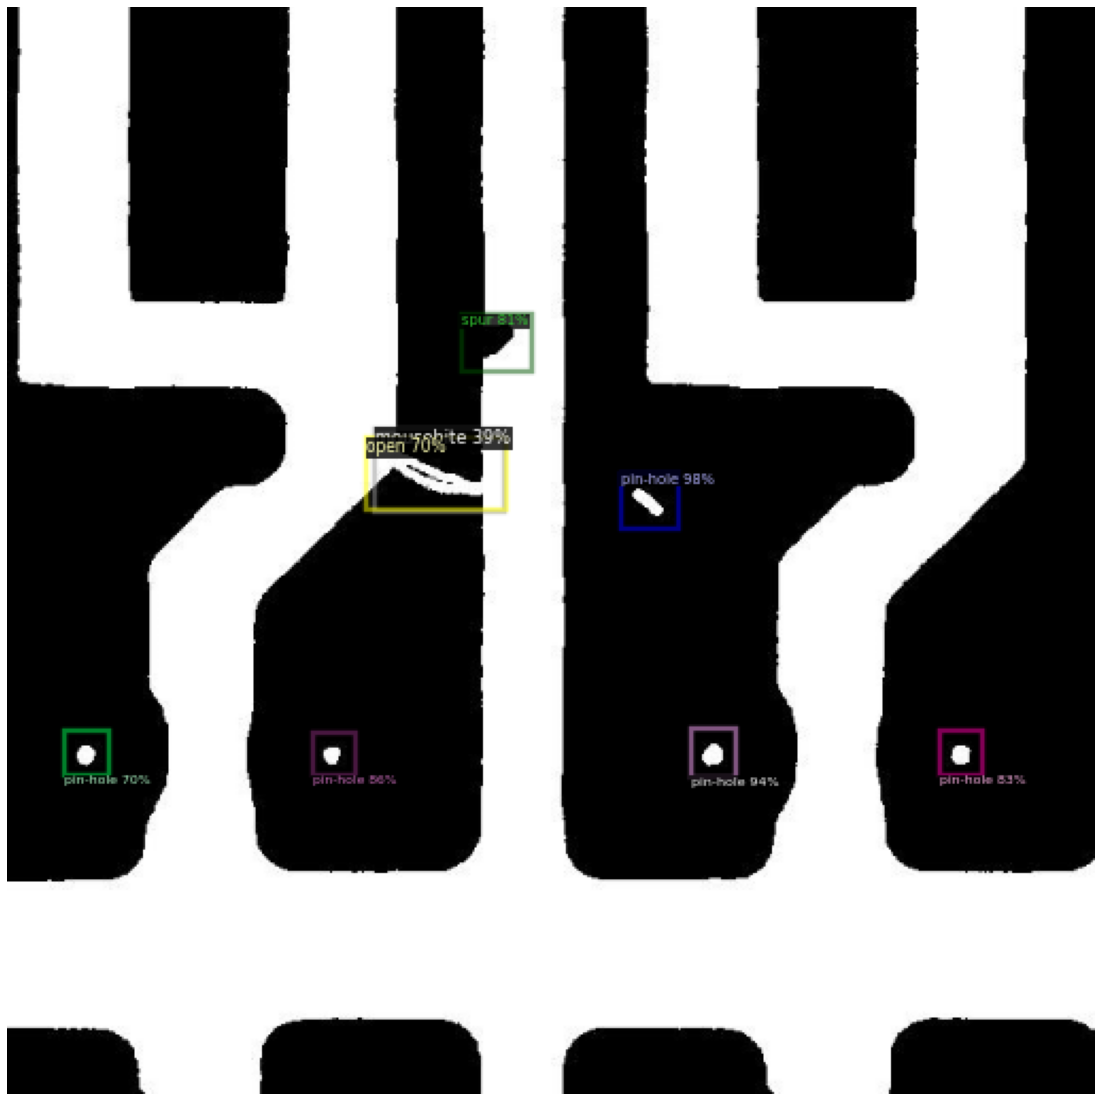

tensor([3, 0, 4, 5, 1, 1, 3], device='cuda:0')
Boxes(tensor([[308.1906, 345.6046, 335.9494, 383.5642],
        [589.9222, 311.6241, 620.2717, 342.7240],
        [200.6330, 114.2710, 244.5484, 144.7884],
        [202.9031, 115.3767, 241.2132, 140.9114],
        [557.5641, 517.8889, 610.6152, 545.3143],
        [308.4610, 268.1742, 373.5242, 288.6466],
        [557.1931, 519.2256, 610.7139, 544.1945]], device='cuda:0'))


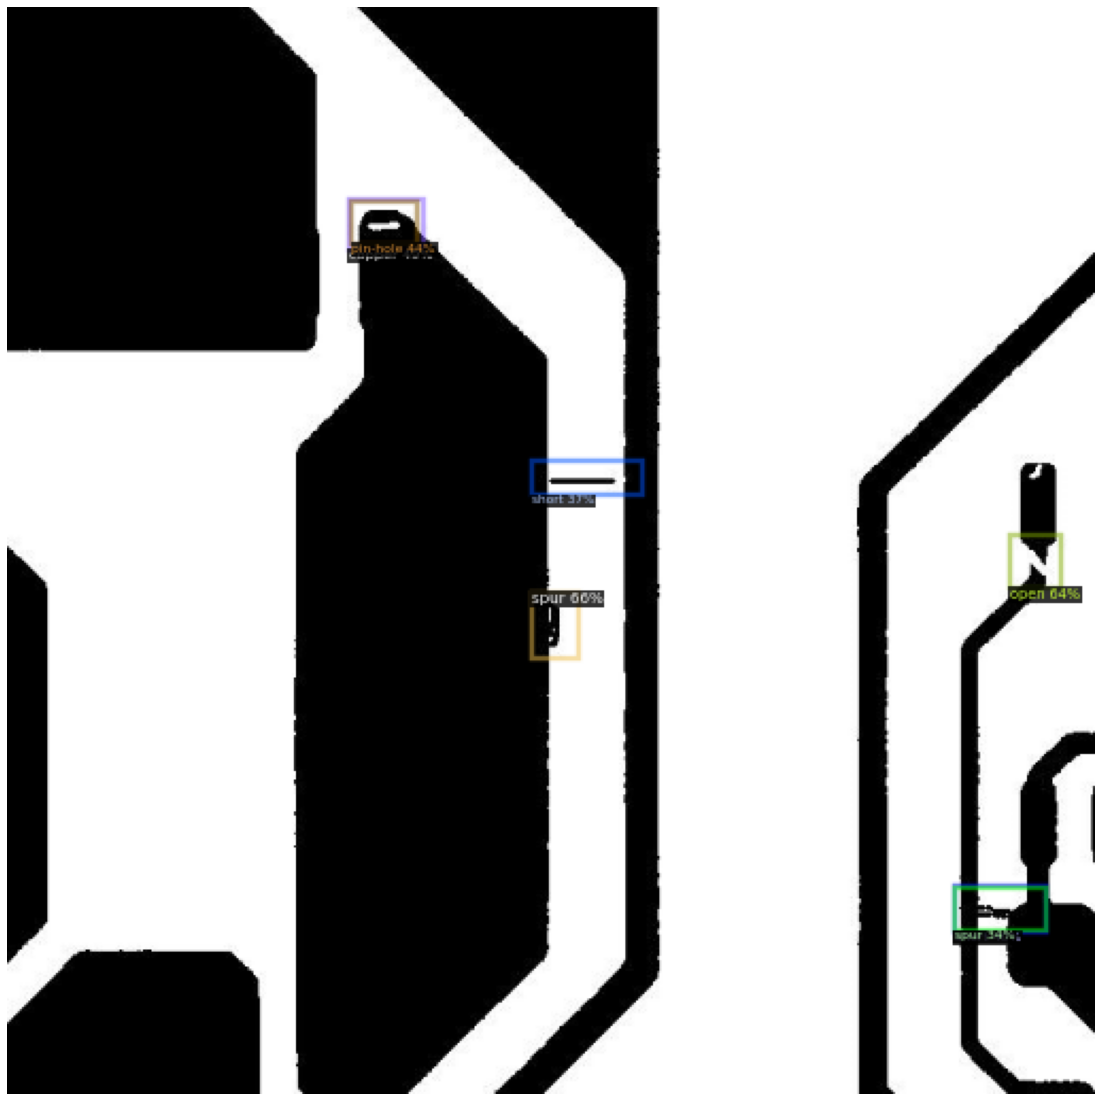

tensor([5, 3, 1, 1, 1, 1, 0, 2, 0, 2], device='cuda:0')
Boxes(tensor([[ 82.7008, 268.5692, 108.6992, 290.6514],
        [289.1826, 147.3510, 315.9657, 171.8385],
        [362.0842, 253.7530, 417.2271, 280.8136],
        [ 76.4779, 423.3463, 100.2609, 473.6710],
        [171.8518, 461.9247, 193.8557, 529.5367],
        [334.5290, 424.9926, 359.4639, 472.9796],
        [159.1983, 152.7502, 196.7659, 179.6756],
        [244.4209, 499.0367, 271.2819, 524.7990],
        [301.6763, 259.7810, 329.2070, 286.4644],
        [158.8300, 150.9978, 198.9867, 179.6069]], device='cuda:0'))


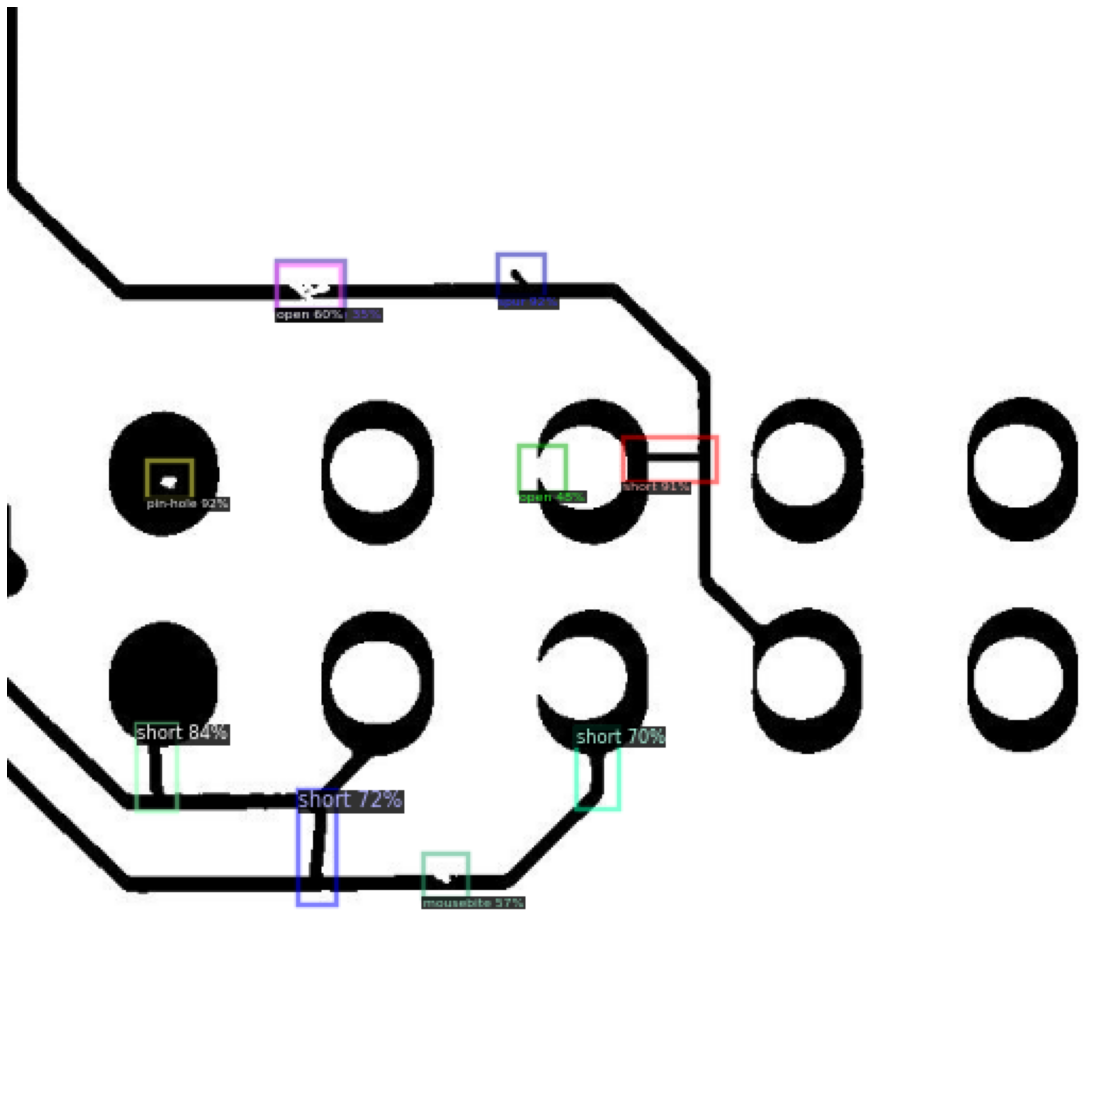

tensor([4, 3, 0, 0, 0, 2, 2], device='cuda:0')
Boxes(tensor([[326.5097, 129.0727, 355.5371, 158.0018],
        [200.2228, 135.2736, 231.8983, 159.5381],
        [108.6780, 133.6885, 139.5686, 155.9401],
        [193.9443,  60.9496, 221.5389, 105.4377],
        [195.8808, 188.4712, 221.4272, 219.9113],
        [196.3292, 187.2329, 221.5188, 222.1311],
        [195.3367,  57.2019, 221.3141, 106.5973]], device='cuda:0'))


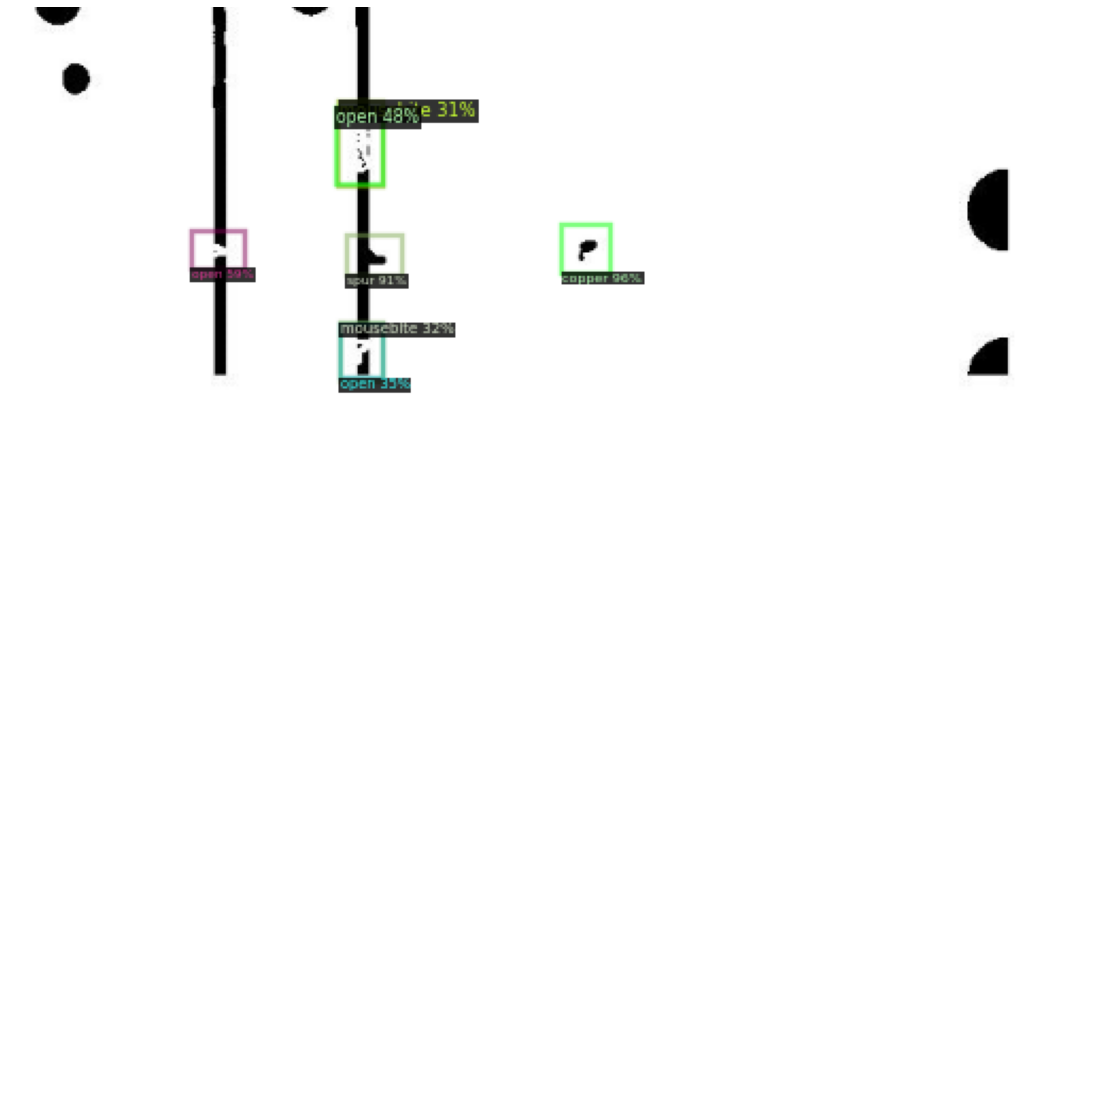

In [16]:
for d in random.sample(dataset_dicts, 10):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im,
                   metadata=PCB_metadata, 
                   scale=0.8,
                   instance_mode =  ColorMode.IMAGE
        )
                   # remove the colors of unsegmented pixels
    print(outputs['instances'].pred_classes)
    print(outputs["instances"].pred_boxes)

    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image())

In [17]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset, LVISEvaluator
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("PCB_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "PCB_test")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

串流輸出內容已截斷至最後 5000 行。
{'bbox': [50.0, 428.0, 80.0, 460.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 2, 'iscrowd': 0}
['12', '261', '47', '312', '2']
[12.0, 261.0, 47.0, 312.0]
{'bbox': [12.0, 261.0, 47.0, 312.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 1, 'iscrowd': 0}
['494', '501', '524', '536', '3']
[494.0, 501.0, 524.0, 536.0]
{'bbox': [494.0, 501.0, 524.0, 536.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 2, 'iscrowd': 0}
['215', '565', '244', '602', '4']
[215.0, 565.0, 244.0, 602.0]
{'bbox': [215.0, 565.0, 244.0, 602.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 3, 'iscrowd': 0}
['411', '309', '444', '342', '6']
[411.0, 309.0, 444.0, 342.0]
{'bbox': [411.0, 309.0, 444.0, 342.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 5, 'iscrowd': 0}
['183', '516', '219', '541', '3']
[183.0, 516.0, 219.0, 541.0]
{'bbox': [183.0, 516.0, 219.0, 541.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 2, 'iscrowd': 0}
['287', '425', '322', '455', '

OrderedDict([('bbox',
              {'AP': 48.856593254536776,
               'AP-copper': 78.45911312573186,
               'AP-mousebite': 50.000505759694526,
               'AP-open': 36.76417305608842,
               'AP-pin-hole': 63.53028738864565,
               'AP-short': 23.159908726431837,
               'AP-spur': 41.225571470628346,
               'AP50': 82.90932356403664,
               'AP75': 49.817722348258584,
               'APl': 59.999999999999986,
               'APm': 51.14325870167546,
               'APs': 45.36640408864904})])